In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

from matplotlib.ticker import MultipleLocator

In [3]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning

## Distance modulus

In [36]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59723.65 # t_0 in salt3
ebv = 0.04
rv = 3.1

# tfl = 58972.46296299994


### IPAC velocity calculator

- $z=0.02736$, $v = cz = 8202.3$ km/s, $v_\mathrm{CMB} = 8346.4$ km/s

In [6]:
C = 299792.458
print(C * z, C * (z + z_unc), C * (z - z_unc))


8202.32165088 8223.30712294 8181.336178819999


### Cosmic flow

- $\Omega_M=0.3$, $h_0=0.7$

In [9]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

mu = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(mu))


Comoving distances = 114.48 Mpc
Distance modulus = 35.29


## Light curves

In [10]:
import pandas as pd
from astropy.table import Table

In [11]:
joj_lc = pd.read_csv('./SN2022joj_lc.csv')
joj_lc['MJD'] = joj_lc['mjd']
# joj_ZTF = joj_lc[joj_lc['instrument_name'] == 'ZTF']
joj_UVOT = joj_lc[joj_lc['instrument_name'] == 'UVOT']


In [12]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 50) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [37]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

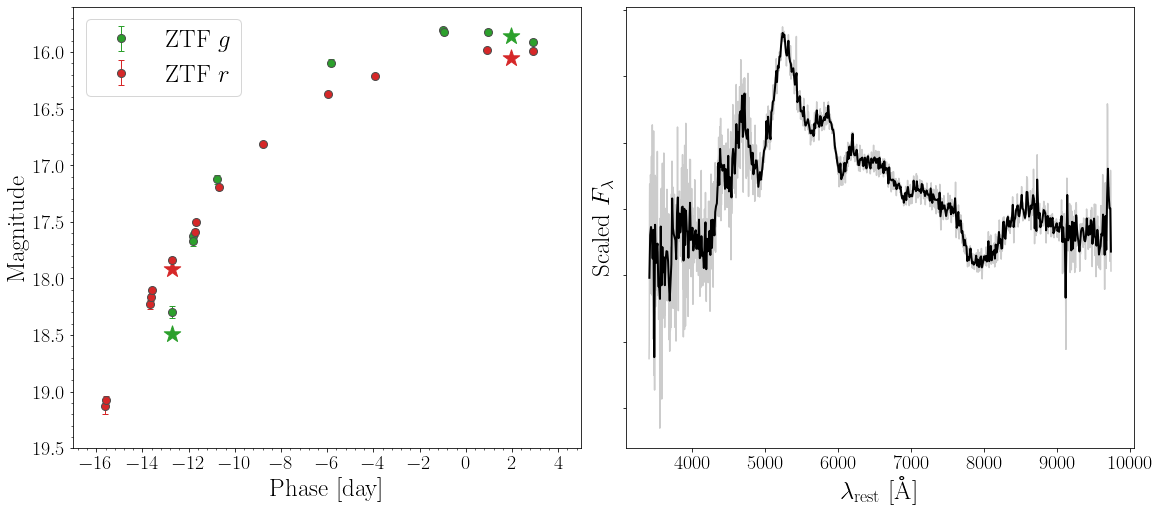

In [14]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(16, 7))
ax[0].errorbar(joj_ZTF_g['phase'], joj_ZTF_g['mag'], yerr=[joj_ZTF_g['mag_err_l'],
                                                           joj_ZTF_g['mag_err_u']], fmt='o', markersize=8, capsize=3, color='tab:green',
               markeredgecolor='.3', elinewidth=1,
               label=r'$\mathrm{ZTF}\ g$')
ax[0].errorbar(joj_ZTF_r['phase'], joj_ZTF_r['mag'], yerr=[joj_ZTF_r['mag_err_l'], joj_ZTF_r['mag_err_u']],
               fmt='o', markersize=8, capsize=3, color='tab:red',
               markeredgecolor='.3', elinewidth=1,
               label=r'$\mathrm{ZTF}\ r$')

ax[0].set_xlabel(r'$\mathrm{Phase\ [day]}$')
ax[0].set_ylabel(r'$\mathrm{Magnitude}$')
ax[0].set_xlim(-17, 5)
ax[0].set_ylim(19.5, 15.6)

ax[0].xaxis.set_minor_locator(MultipleLocator(0.4))
ax[0].xaxis.set_major_locator(MultipleLocator(2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[0].legend()

spec1 = np.loadtxt(
    '../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii')
ax[1].plot(spec1[:, 0] / (1 + z), spec1[:, 1], color='0.8')
spec1 = data_binning(
    np.array([spec1[:, 0], spec1[:, 1], np.ones_like(spec1[:, 0])]).T, size=10)
ax[1].plot(spec1[:, 0] / (1 + z), spec1[:, 1], color='k', linewidth=2)
ax[1].set_yticklabels([])
ax[1].set_xlabel(r'$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$')
ax[1].set_ylabel(r'$\mathrm{Scaled}\ F_\lambda$')

# plt.savefig('SN2022joj_rise.pdf', bbox_inches='tight')

ax[0].scatter((59710.28841435185 - t_max_mjd) / (1 + z), 18.489878206067814, color='tab:green', marker='*', s=300)
ax[0].scatter((59710.28841435185 - t_max_mjd) / (1 + z), 17.913686945112794, color='tab:red', marker='*', s=300)

ax[0].scatter((59725.34359680023 - t_max_mjd) / (1 + z), 15.860769487179802, color='tab:green', marker='*', s=300)
ax[0].scatter((59725.34359680023 - t_max_mjd) / (1 + z), 16.055376644872744, color='tab:red', marker='*', s=300)


## SALT3 fit

In [38]:
joj_SALT = {}
lc = joj_ZTF.copy()
arg = ((lc['MJD'] - t_max_mjd) / (1 + z) <= 50) & ((lc['MJD'] - t_max_mjd) / (1 + z) >= -25)
joj_SALT['time'] = lc['MJD'][arg]
joj_SALT['band'] = lc['passband'][arg]
joj_SALT['flux'] = lc['fnu_microJy'][arg]
joj_SALT['fluxerr'] = lc['fnu_microJy_unc'][arg]
joj_SALT['zp'] = [2.5 * np.log10(3631 * 1e6)] * len(lc[arg])
joj_SALT['zpsys'] = ['ab'] * len(lc[arg])
joj_SALT = Table(joj_SALT)


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/iminuit/util.py:183: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


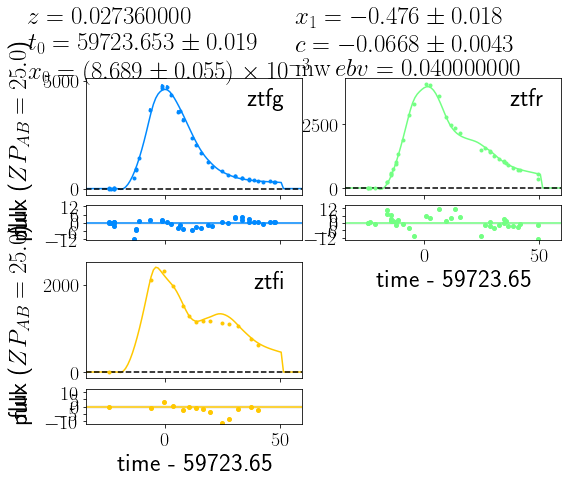

In [39]:
import sncosmo

model = sncosmo.Model(source='salt3', effects=[
                      sncosmo.F99Dust()], effect_names=['mw'], effect_frames=['obs'])
model.set(z=z, mwebv=ebv)

result, fitted_model = sncosmo.fit_lc(
    joj_SALT, model,
    ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(joj_SALT, model=fitted_model, errors=result.errors)

In [42]:
from copy import deepcopy

peakphase_B = fitted_model.source.peakphase('bessellb')
m1 = fitted_model.source.bandmag('bessellb', 'ab', peakphase_B)
m2 = fitted_model.source.bandmag('bessellb', 'ab', peakphase_B + 15)

print('t_max_B = {:.2f}'.format(peakphase_B))
print('delta M_15 = {:.2f}'.format(m2 - m1))

t_max_B = -0.51
delta M_15 = 1.16


In [43]:
dered_model = deepcopy(fitted_model)
dered_model.set(mwebv=0)
print(dered_model.source.bandmag(band="bessellb", phase=peakphase_B, magsys="ab") - mu)
print(dered_model.source.bandmag(band="bessellv", phase=peakphase_B, magsys="ab") - mu)
print(
    dered_model.source.bandmag(band="bessellb", phase=peakphase_B, magsys="ab")
    - dered_model.source.bandmag(band="bessellv", phase=peakphase_B, magsys="ab")
)

-19.63151900336282
-19.454163122333618
-0.17735588102919841


## Early rise

In [15]:
import pymc as pm
import arviz as az

In [66]:
joj_ZTF_r_rise = joj_ZTF_r[((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z) <= -10)
                           & ((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z) >= -25)]
MJD_pred = np.linspace(-25, -10, 100) + t_max_mjd
with pm.Model() as rise_MJD:
    t_exp = pm.Uniform('t_exp', joj_ZTF_r_rise['MJD'].values[0], joj_ZTF_r_rise['MJD'].values[-1])
    alpha = pm.Normal('alpha', 2, 1)
    log_A = pm.Normal('log_A', 1, 1)
    phase = joj_ZTF_r_rise['MJD'].values - t_exp
    flux = pm.Deterministic(
        'flux', 10**log_A * ((phase + np.abs(phase))/2)**alpha)
    flux_obs = pm.Normal(
        'flux_obs', flux, joj_ZTF_r_rise['fnu_microJy_unc'].values, observed=joj_ZTF_r_rise['fnu_microJy'].values)
    flux_pred = pm.Deterministic('flux_pred',
                                 10**log_A * (((MJD_pred - t_exp) + np.abs(MJD_pred - t_exp))/2)**alpha)
    trace_MJD = pm.sample(return_inferencedata=True, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_exp, alpha, log_A]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.9187, but should be close to 0.8. Try to increase the number of tuning steps.


In [67]:
summary = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if not 'flux' in var])
summary_pred = az.summary(trace_MJD, hdi_prob=0.68, var_names=[var for var in trace_MJD.posterior.data_vars if 'pred' in var])
summary

/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.351,0.272,2.035,2.561,0.014,0.010,398.0,495.0,1.02
log_A,0.346,0.351,0.104,0.770,0.018,0.013,397.0,494.0,1.02
t_exp,59702.650,0.800,59702.103,59703.640,0.041,0.029,398.0,542.0,1.02


In [71]:
rise_time = ((t_max_mjd + peakphase_B) - summary['mean']['t_exp']) / (1 + z)
rise_time

19.94211752829478

<ErrorbarContainer object of 3 artists>

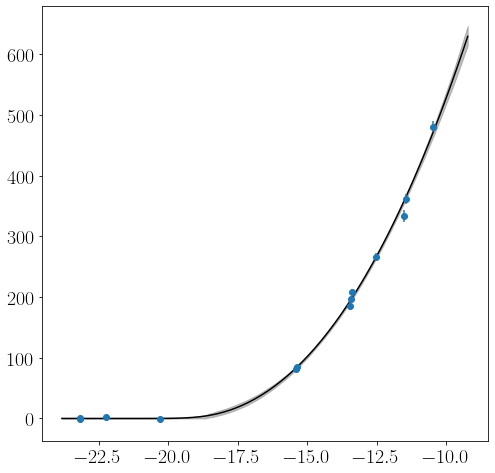

In [65]:
plt.figure(figsize=(8, 8))
plt.plot((MJD_pred - t_max_mjd) / (1 + z) - peakphase_B, summary_pred["mean"], color="k")
plt.fill_between(
    (MJD_pred - t_max_mjd) / (1 + z) - peakphase_B, summary_pred["hdi_16%"], summary_pred["hdi_84%"], color="0.5", alpha=0.5
)
plt.errorbar(
    (joj_ZTF_r_rise["MJD"].values - t_max_mjd) / (1 + z) - peakphase_B,
    joj_ZTF_r_rise["fnu_microJy"].values,
    yerr=joj_ZTF_r_rise["fnu_microJy_unc"].values,
    fmt="o",
)
# plt.yscale('log')
# plt.xlim(-17, -10)
# plt.ylim(50, 550)

## Color evolution

In [72]:
def mag1_mag2(X, Y, bin_size=1, flux=False):
    '''
    calculate the color using multi-band photometry
    
    Parameters
    ----------
    X, Y : array-like
        X-, Y-band photometry
        column 1 - obs time (day)
        column 2 - magnitude/flux
        column 3 - (symmetric) uncertainty
        column 4 & 5 (optional) - (upper & lower) uncertainty
    bin_size : float, default = 1 (day)
        the maximum allowed offset of the obs times for the X-
        and Y-band photometry to calculate the color
    flux : bool, default = False
        whether to estimate the color uncertainty from the uncertainty
        of flux ratio, needs column 4 & 5 from X, Y
    '''
    t1, t2 = X[:, 0], Y[:, 0]
    if not flux:
        mag1, mag2 = X[:, 1], Y[:, 1]
        unc1, unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc = [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    t = (t1[i] / unc1[i]**2 + t2[j] / unc2[j]**2) / (
                        1 / unc1[i]**2 + 1 / unc2[j]**2)
                    mag = (mag1[i] - mag2[j])
                    unc = (unc1[i]**2 + unc2[j]**2)**.5
                    T = np.append(T, t)
                    dmag = np.append(dmag, mag)
                    Unc = np.append(Unc, unc)
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc < 999).flatten()
        return T[arg], dmag[arg], Unc[arg]
    else:
        f1, f2 = X[:, 1], Y[:, 1]
        f_unc1, f_unc2 = X[:, 2], Y[:, 2]
        i, j = 0, 0
        T = []
        dmag, Unc_u, Unc_l = [], [], []
        while i < len(t1):
            while j < len(t2):
                if t2[j] >= t1[i] + bin_size:
                    break
                if (np.abs(t2[j] - t1[i]) < bin_size):
                    if f1[i] <= f_unc1[i] or f2[j] <= f_unc2[j]:
                        j += 1
                        continue
                    f12 = f1[i] / f2[j]
                    f12unc = f12 * ((f_unc1[i] / f1[i])**2 +
                                    (f_unc2[j] / f2[j])**2)**.5
                    t = (t1[i] / f_unc1[i]**2 + t2[j] / f_unc2[j]**2) / (
                        1 / f_unc1[i]**2 + 1 / f_unc2[j]**2)
                    T = np.append(T, t)
                    dmag = np.append(dmag, -2.5 * np.log10(f12))
                    Unc_u = np.append(Unc_u,
                                      -2.5 * np.log10(f12 / (f12 + f12unc)))
                    Unc_l = np.append(Unc_l, -2.5 * np.log10(
                        (f12 - f12unc) / f12))
                    break
                j += 1
            i += 1
        arg = np.argwhere(Unc_l < 999).flatten()
        return T[arg], dmag[arg], [Unc_u[arg], Unc_l[arg]]

(1, 100)

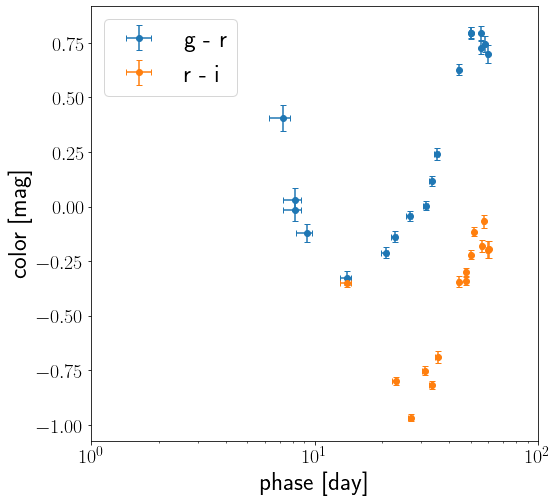

In [83]:
leff_g = 4722.74  # AA
leff_r = 6339.61  # AA
leff_i = 7886.13  # AA
rv = 3.1
ebv = 0.04

t_exp = -((t_max_mjd + peakphase_B) - summary["mean"]["t_exp"]) / (1 + z)
t_exp_lo = -((t_max_mjd + peakphase_B) - summary["hdi_16%"]["t_exp"]) / (1 + z)
t_exp_up = -((t_max_mjd + peakphase_B) - summary["hdi_84%"]["t_exp"]) / (1 + z)

g_r_cor = calALambda(leff_g, EBV=ebv, RV=rv) - calALambda(leff_r, EBV=ebv, RV=rv)
r_i_cor = calALambda(leff_r, EBV=ebv, RV=rv) - calALambda(leff_i, EBV=ebv, RV=rv)

ZTFg = np.array(
    [joj_ZTF_g["phase"], joj_ZTF_g["fnu_microJy"], joj_ZTF_g["fnu_microJy_unc"]]
).T
ZTFr = np.array(
    [joj_ZTF_r["phase"], joj_ZTF_r["fnu_microJy"], joj_ZTF_r["fnu_microJy_unc"]]
).T
ZTFi = np.array(
    [joj_ZTF_i["phase"], joj_ZTF_i["fnu_microJy"], joj_ZTF_i["fnu_microJy_unc"]]
).T

plt.figure(figsize=(8, 8))

phase, g_r, g_r_unc = mag1_mag2(ZTFg, ZTFr, flux=True, bin_size=0.5)
plt.errorbar(
    phase - t_exp,
    g_r - g_r_cor,
    xerr=[[t_exp_lo - t_exp], [t_exp - t_exp_up]],
    yerr=g_r_unc,
    fmt="o",
    capsize=3,
    label="g - r",
)
phase, r_i, r_i_unc = mag1_mag2(ZTFr, ZTFi, flux=True)
plt.errorbar(
    phase - t_exp,
    r_i - r_i_cor,
    xerr=[[t_exp_lo - t_exp], [t_exp - t_exp_up]],
    yerr=r_i_unc,
    fmt="o",
    capsize=3,
    label="r - i",
)

plt.xscale('log')

plt.ylabel("color [mag]")
plt.xlabel("phase [day]")
plt.legend()

plt.xlim(1, 100)

## 1-D DDet models

In [31]:
import h5py

spec1 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii')
spec1 = data_binning(np.array([spec1[:, 0], spec1[:, 1], np.ones_like(spec1[:, 0])]).T, size=10)
spec2 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt')
spec3 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220601_NOT_ALFOSC.ascii')

### Polin+2019

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


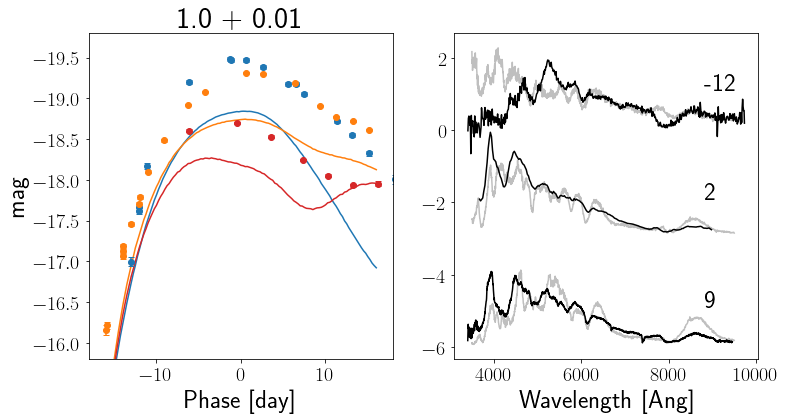

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


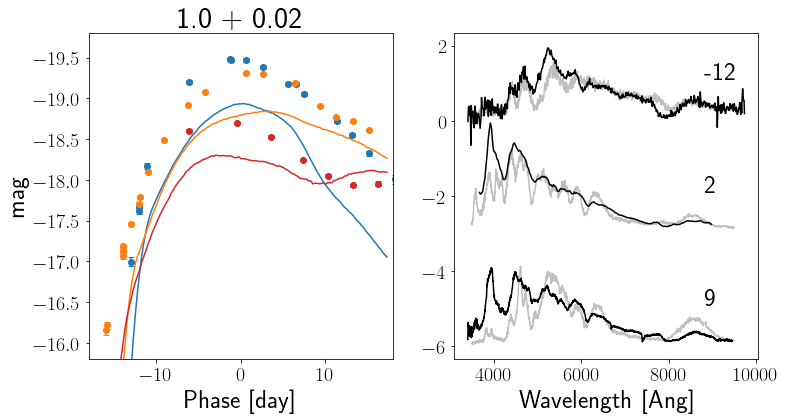

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


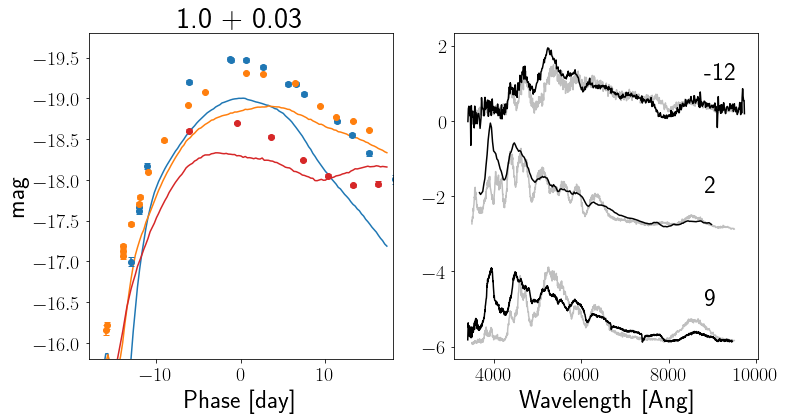

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


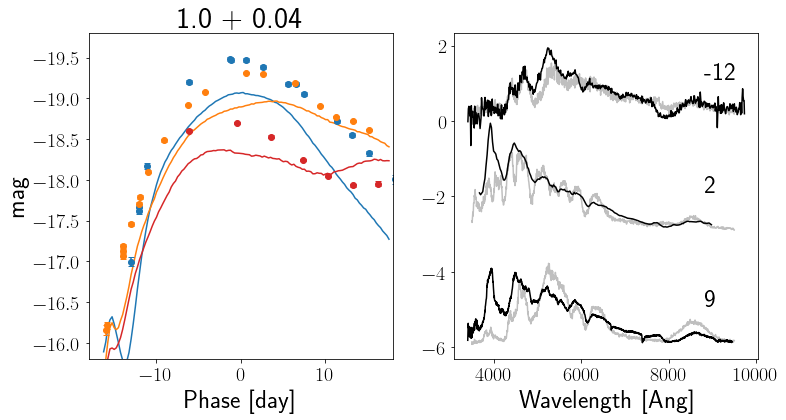

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


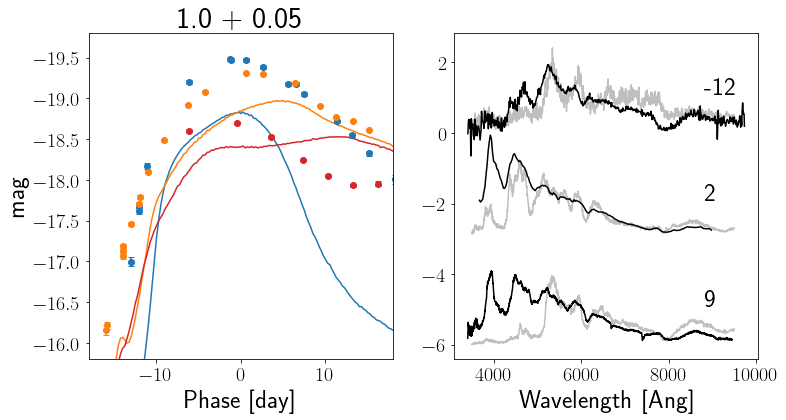

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


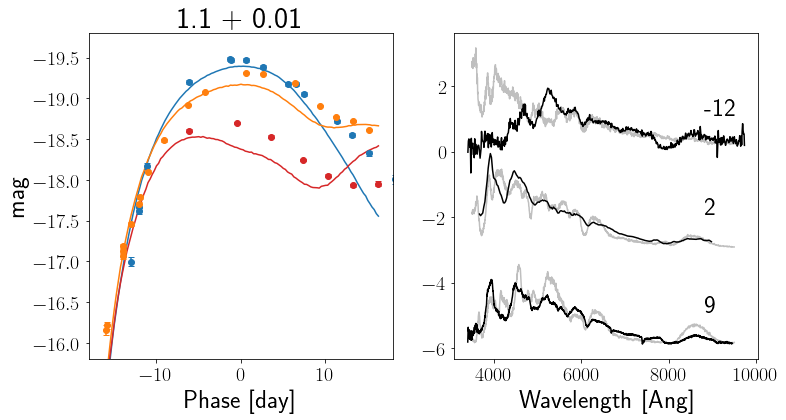

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


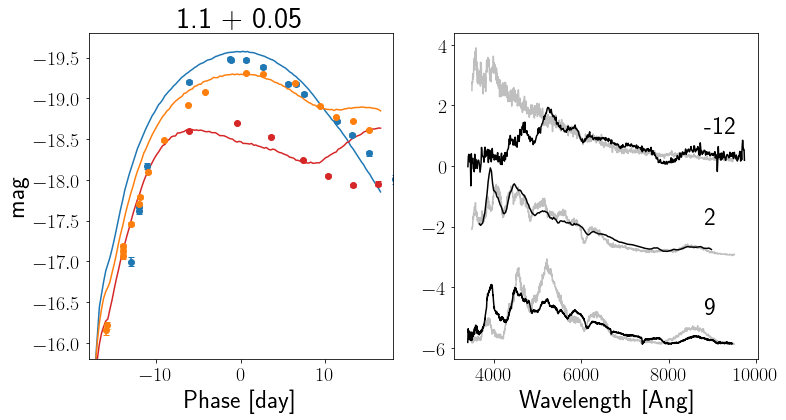

In [84]:
models = sorted(glob.glob(
    '/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.*'))
filters = sorted(glob.glob('./filters/*'))

peakphase_g = fitted_model.source.peakphase('ztfg')

for model in models:
    mod = model.split('/')[-1]
    mc, ms = mod.split('_')[-3], mod.split('_')[-2]
    if (float(ms) > 0.05) or (float(ms) < 0.01) or (float(mc) > 1.1):
        continue
    with h5py.File(model, 'r') as f:
        Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
        time = np.array(f['time'][:] / 86400)
        nu = np.array(f['nu'][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array([(np.flip(fnu)).to(
            u.erg / u.s / u.cm**2 / u.AA,
            equivalencies=u.spectral_density(wv * u.AA))
            for fnu in Fnu]) / (1 + z)
        E_Gal = 10**(-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10**(-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag([wv, fl, np.ones_like(
            wv, dtype=float)], flt=np.loadtxt(filters[0]))[0]
        fit_r[k] = spec_to_mag([wv, fl, np.ones_like(
            wv, dtype=float)], flt=np.loadtxt(filters[1]))[0]
        fit_g[k] = spec_to_mag([wv, fl, np.ones_like(
            wv, dtype=float)], flt=np.loadtxt(filters[2]))[0]
    t_max = time[ind][np.argmin(fit_g)] - peakphase_g # g-band peak to t_0

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(time[ind] - t_max, fit_g, color='tab:blue')
    ax[0].plot(time[ind] - t_max, fit_r, color='tab:orange')
    ax[0].plot(time[ind] - t_max, fit_i, color='tab:red')
    
    ax[0].errorbar((joj_ZTF_g['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_g['mag'] -
                   mu, yerr=[joj_ZTF_g['mag_err_l'], joj_ZTF_g['mag_err_u']], fmt='o', capsize=3, color='tab:blue')
    ax[0].errorbar((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_r['mag'] -
                   mu, yerr=[joj_ZTF_r['mag_err_l'], joj_ZTF_r['mag_err_u']], fmt='o', capsize=3, color='tab:orange')
    ax[0].errorbar((joj_ZTF_i['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_i['mag'] -
                   mu, yerr=[joj_ZTF_i['mag_err_l'], joj_ZTF_i['mag_err_u']], fmt='o', capsize=3, color='tab:red')
    ax[0].invert_yaxis()
    ax[0].set_ylim(-15.8, -19.8)
    ax[0].set_xlim(-18, 18)
    ax[0].set_xlabel('Phase [day]')
    ax[0].set_ylabel('mag')
    ax[0].set_title(f'{mc} + {ms}')

    idx_wv = (wv0 > 3500) & (wv0 < 9500)
    phases = np.array([-12.50, 2.16, 8.66])
    specs = [spec1, spec2, spec3]
    for k in range(3):
        phase_idx = np.argmin(np.abs(time - (t_max + peakphase_B + phases[k])))
        ax[1].plot(wv0[idx_wv], Flam[phase_idx][idx_wv] / np.median(Flam[phase_idx]
                [(wv0 > 5500) & (wv0 < 6500)]) - 3 * k, color='.5', alpha=.5)
        ax[1].plot(specs[k][:, 0]/(1+z), specs[k][:, 1] / np.median(specs[k][:, 1]
                [(specs[k][:, 0]/(1+z) > 5500) & (specs[k][:, 0]/(1+z) < 6500)]) - 3 * k, color='k')
        ax[1].text(s='{:.0f}'.format(phases[k]), x=8800, y=1.1 - 3 * k, color='k')
    ax[1].set_xlabel('Wavelength [Ang]')
    plt.show()


### Shen+2021

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


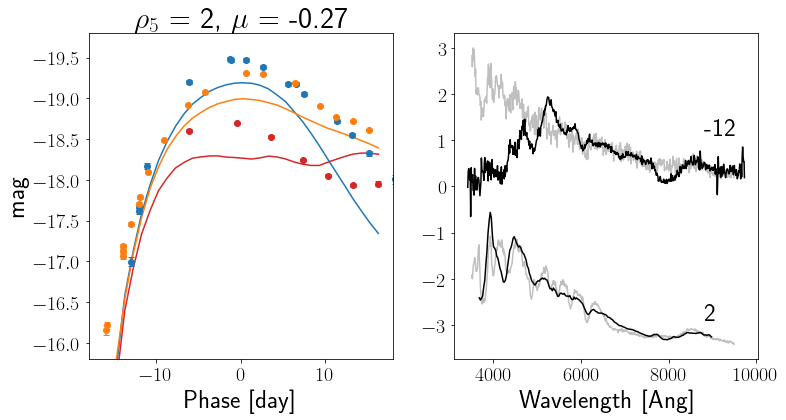

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


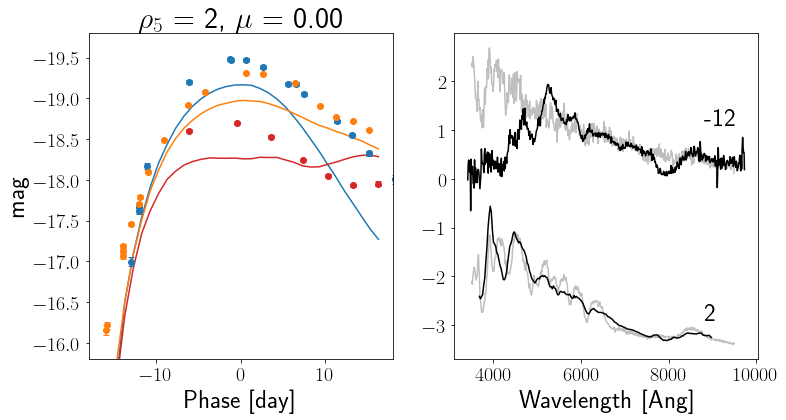

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


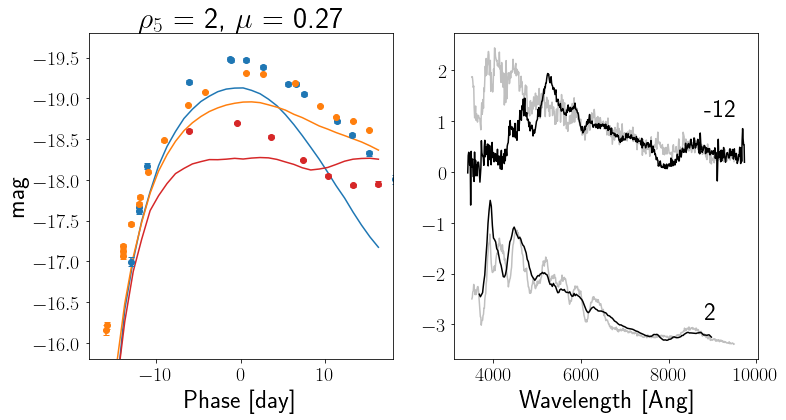

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


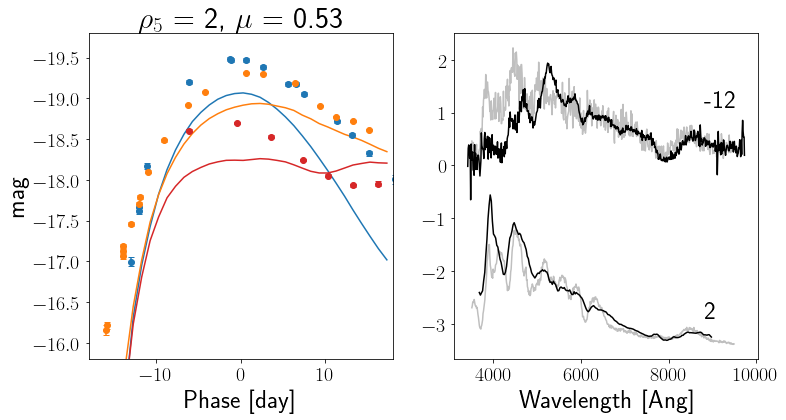

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


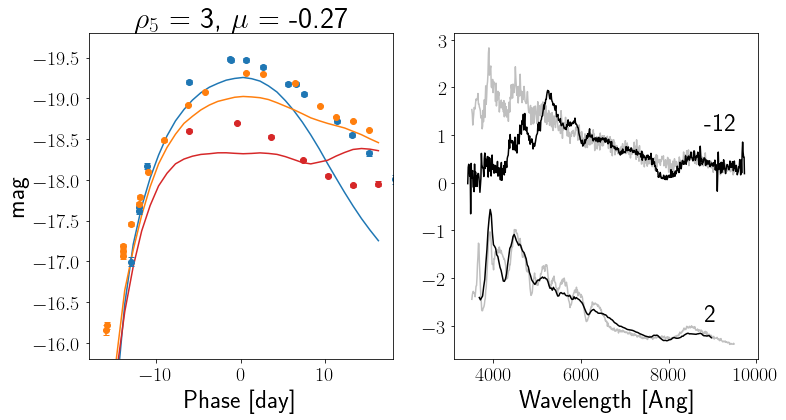

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


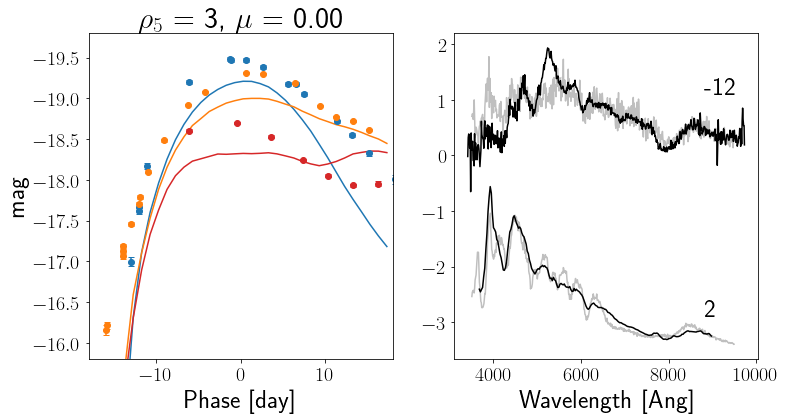

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


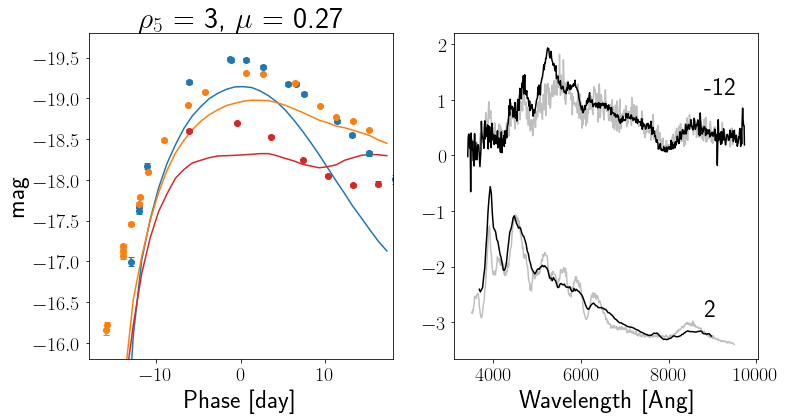

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


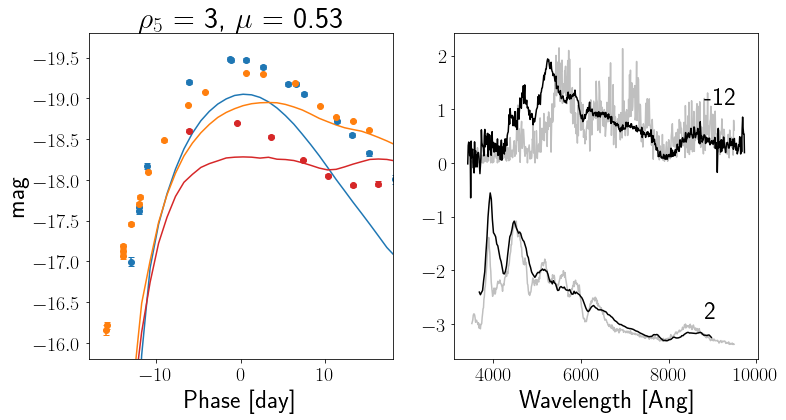

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


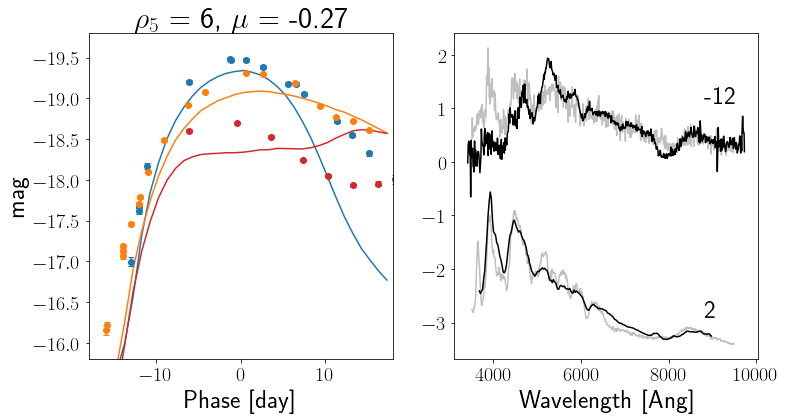

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


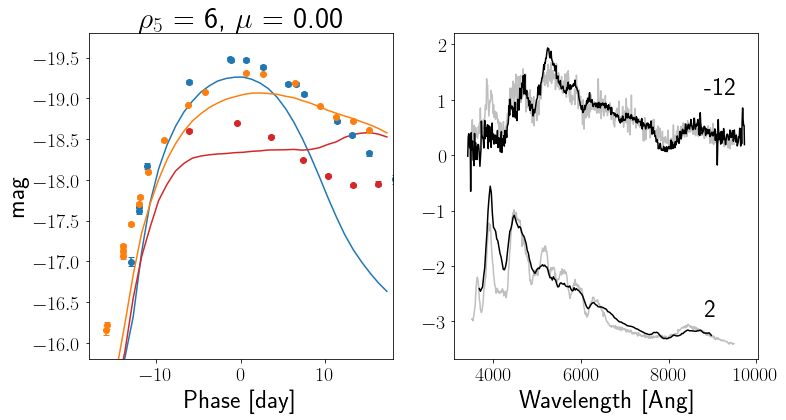

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


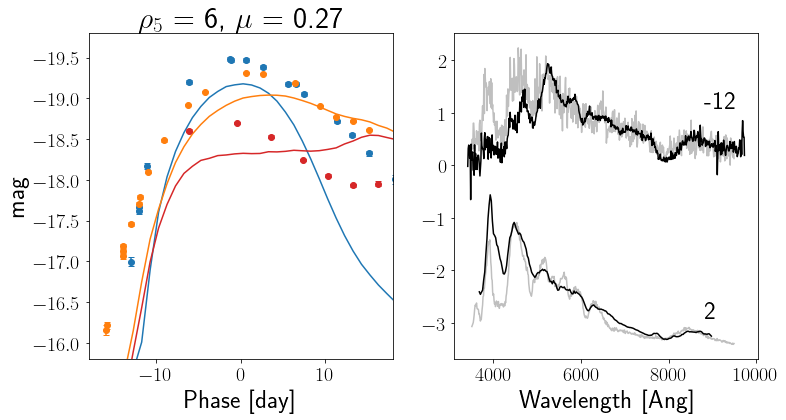

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


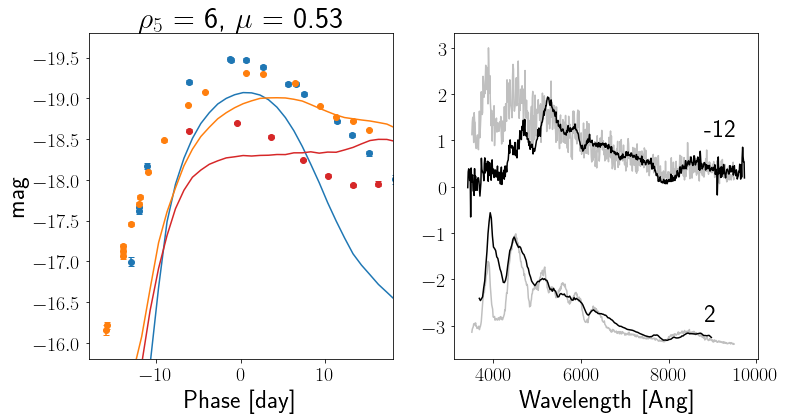

In [86]:
models = sorted(glob.glob(
    '/Users/chang/Desktop/SNIa/Shen2021/1.0_?e5.h5'))
filters = sorted(glob.glob('./filters/*'))

peakphase_g = fitted_model.source.peakphase('ztfg')

for model in models:
    # mod = model.split('/')[-1]
    # mc, ms = mod.split('_')[-3], mod.split('_')[-2]
    # if (float(ms) > 0.05) or (float(ms) < 0.02) or (float(mc) > 1.1):
    #     continue
    
    with h5py.File(model, 'r') as f:
        rho = model.split('_')[-1].split('.')[0][:-2]
        cos_theta = np.array(f['mu'])
        Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
        time = np.array(f['time'][:] / 86400)
        nu = np.array(f['nu'][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = [np.array([(np.flip(fnu[:, i])).to(
            u.erg / u.s / u.cm**2 / u.AA,
            equivalencies=u.spectral_density(wv * u.AA))
            for fnu in Fnu]) / (1 + z) for i in np.arange(len(cos_theta))]
        E_Gal = 10**(-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10**(-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    for i in [5, 7, 9, 11]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag([wv, fl, np.ones_like(
                wv, dtype=float)], flt=np.loadtxt(filters[0]))[0]
            fit_r[k] = spec_to_mag([wv, fl, np.ones_like(
                wv, dtype=float)], flt=np.loadtxt(filters[1]))[0]
            fit_g[k] = spec_to_mag([wv, fl, np.ones_like(
                wv, dtype=float)], flt=np.loadtxt(filters[2]))[0]
        t_max = time[ind][::2][np.argmin(fit_g)] - peakphase_g # g-band peak to t_0
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color='tab:blue')
        ax[0].plot(time[ind][::2] - t_max, fit_r, color='tab:orange')
        ax[0].plot(time[ind][::2] - t_max, fit_i, color='tab:red')
        ax[0].errorbar((joj_ZTF_g['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_g['mag'] -
                       mu, yerr=[joj_ZTF_g['mag_err_l'], joj_ZTF_g['mag_err_u']], fmt='o', capsize=3, color='tab:blue')
        ax[0].errorbar((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_r['mag'] -
                       mu, yerr=[joj_ZTF_r['mag_err_l'], joj_ZTF_r['mag_err_u']], fmt='o', capsize=3, color='tab:orange')
        ax[0].errorbar((joj_ZTF_i['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_i['mag'] -
                       mu, yerr=[joj_ZTF_i['mag_err_l'], joj_ZTF_i['mag_err_u']], fmt='o', capsize=3, color='tab:red')
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel('Phase [day]')
        ax[0].set_ylabel('mag')
        ax[0].set_title(
            r'$\rho_5$ = {}, $\mu$ = {:.2f}'.format(rho, cos_theta[i]))

        idx_wv = (wv0 > 3500) & (wv0 < 9500)
        phases = np.array([-12.50, 2.16])
        specs = [spec1, spec2]
        for k in range(2):
            phase_idx = np.argmin(np.abs(time - (t_max + peakphase_B + phases[k])))
            Flam_bin = data_binning(np.array(
                [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]).T, size=10)
            ax[1].plot(Flam_bin[:, 0], Flam_bin[:, 1] / np.median(Flam_bin[(Flam_bin[:, 0]
                       > 5500) & (Flam_bin[:, 0] < 6500), 1]) - 3.5 * k, color='.5', alpha=.5)
            ax[1].plot(specs[k][:, 0]/(1+z), specs[k][:, 1] / np.median(specs[k][:, 1]
                                                                        [(specs[k][:, 0]/(1+z) > 5500) & (specs[k][:, 0]/(1+z) < 6500)]) - 3.5 * k, color='k')
            ax[1].text(s='{:.0f}'.format(phases[k]), x=8800, y=1.1 - 4 * k, color='k')
        ax[1].set_xlabel('Wavelength [Ang]')
        plt.show()

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


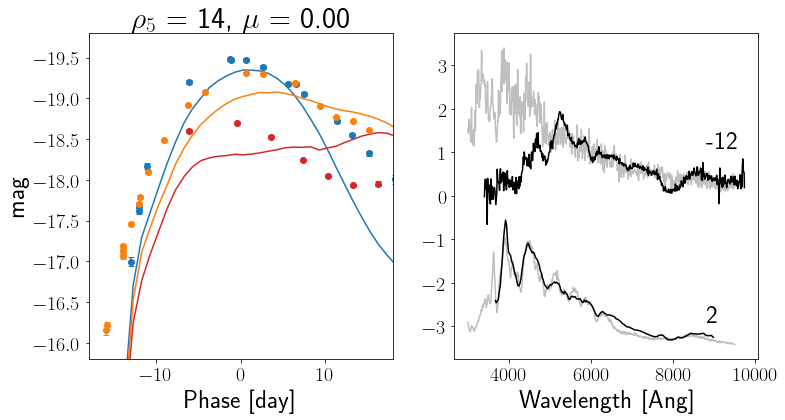

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


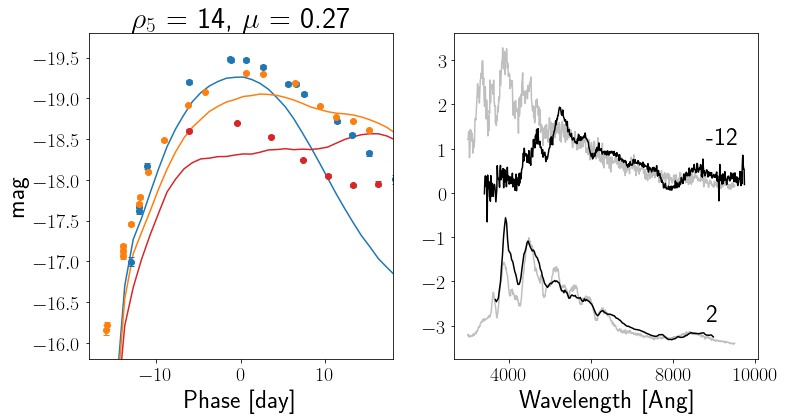

: 

In [119]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_??e5.h5"))
filters = sorted(glob.glob("./filters/*"))

peakphase_g = fitted_model.source.peakphase("ztfg")

for model in models:
    # mod = model.split('/')[-1]
    # mc, ms = mod.split('_')[-3], mod.split('_')[-2]
    # if (float(ms) > 0.05) or (float(ms) < 0.02) or (float(mc) > 1.1):
    #     continue

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            for i in np.arange(len(cos_theta))
        ]
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    for i in [7, 9]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
        t_max = time[ind][::2][np.argmin(fit_g)] - peakphase_g  # g-band peak to t_0
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - mu,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - mu,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - mu,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.50, 2.16])
        specs = [spec1, spec2]
        for k in range(2):
            from scipy.integrate import trapz

            phase_idx = np.argmin(np.abs(time - (t_max + peakphase_B + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            if phases[k] > 0:
                log_Lsun = np.log10(
                    trapz(
                        (Flam[i][phase_idx] / (E_Gal * E_Host))[idx_wv],
                        wv0[idx_wv],
                    )
                    * (4 * np.pi * (10 * u.pc).to("cm").value ** 2)
                    * (1 + z)
                    / 3.828e33  # Lsun in cgs
                )
                np.savetxt(
                    "../TARDIS/Shen+2021/d{}e5_mu_{:.0f}_spec.txt".format(
                        rho, cos_theta[i] * 100
                    ),
                    np.array(
                        [
                            wv0,
                            Flam[i][phase_idx]
                            / (E_Gal * E_Host)
                            * (1 + z)
                            * (10e-6 / 114.48) ** 2, # 10 pc --> D_L Mpc
                        ]
                    ).T[idx_wv, :],
                    fmt="%.4f %.4e",
                    header="time_explosion = {}\n".format(time[phase_idx])
                    + "log_Lsun = {:.2f}".format(log_Lsun),
                )

            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


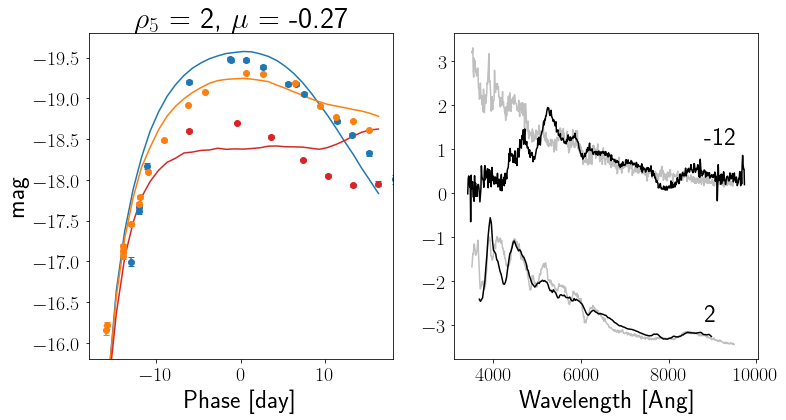

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


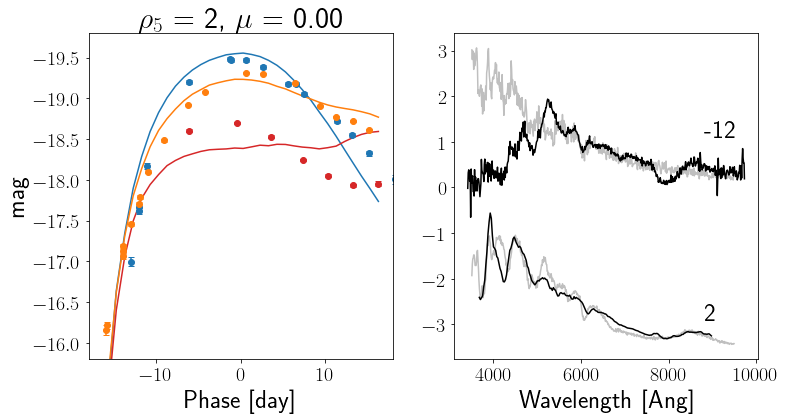

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


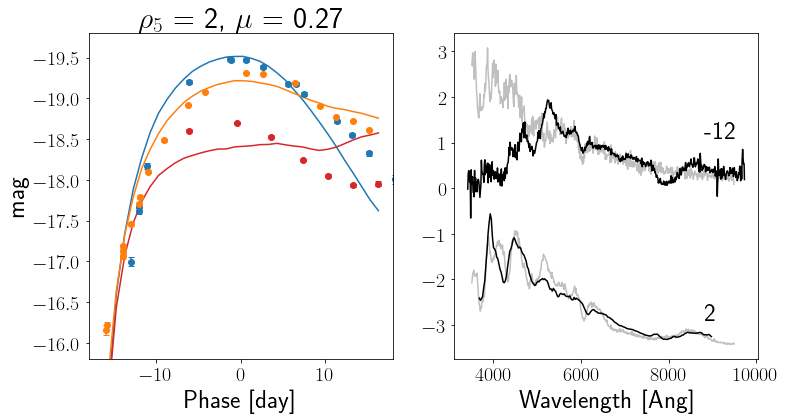

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


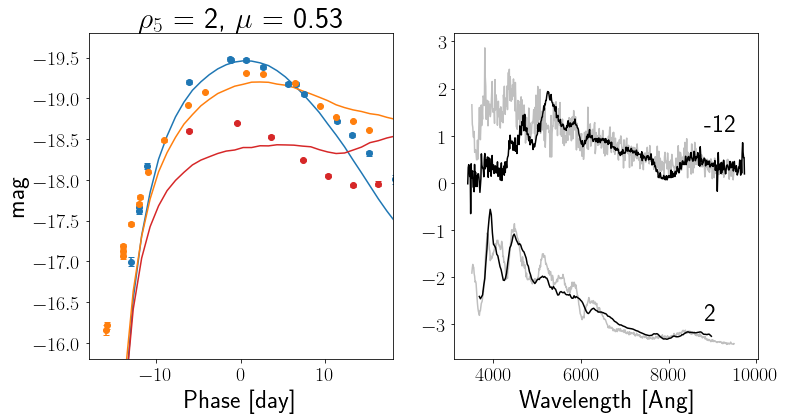

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


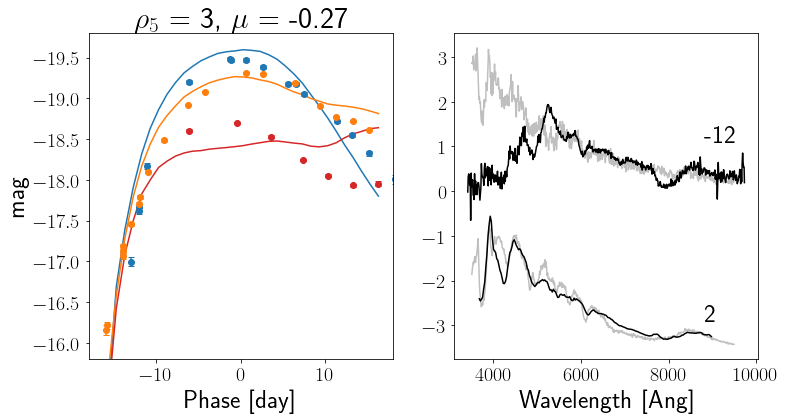

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


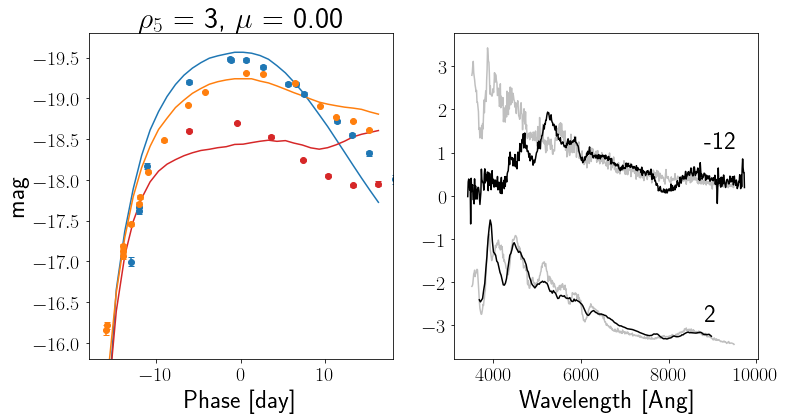

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


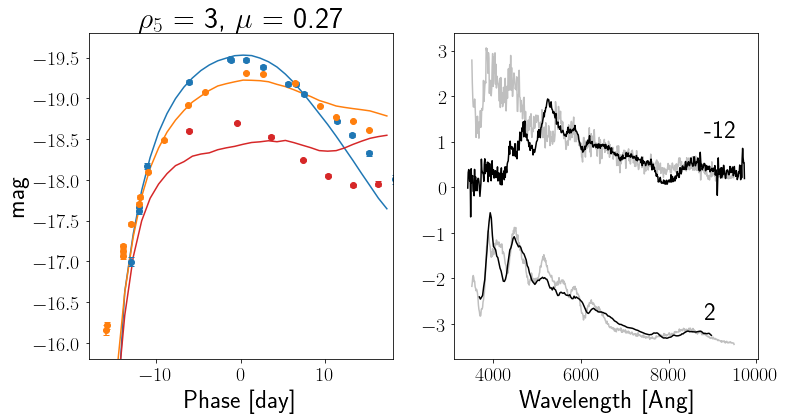

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


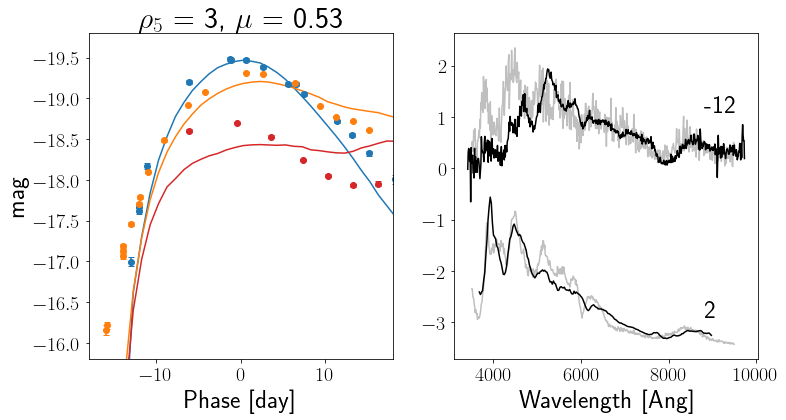

In [88]:
models = sorted(glob.glob(
    '/Users/chang/Desktop/SNIa/Shen2021/1.10_?e5.h5'))
filters = sorted(glob.glob('./filters/*'))

peakphase_g = fitted_model.source.peakphase('ztfg')

for model in models:
    # mod = model.split('/')[-1]
    # mc, ms = mod.split('_')[-3], mod.split('_')[-2]
    # if (float(ms) > 0.05) or (float(ms) < 0.02) or (float(mc) > 1.1):
    #     continue
    
    with h5py.File(model, 'r') as f:
        rho = model.split('_')[-1].split('.')[0][:-2]
        cos_theta = np.array(f['mu'])
        Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
        time = np.array(f['time'][:] / 86400)
        nu = np.array(f['nu'][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = [np.array([(np.flip(fnu[:, i])).to(
            u.erg / u.s / u.cm**2 / u.AA,
            equivalencies=u.spectral_density(wv * u.AA))
            for fnu in Fnu]) / (1 + z) for i in np.arange(len(cos_theta))]
        E_Gal = 10**(-0.4 * calALambda(wv=wv, EBV=0.04, RV=3.1))
        E_Host = 10**(-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    for i in [5, 7, 9, 11]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag([wv, fl, np.ones_like(
                wv, dtype=float)], flt=np.loadtxt(filters[0]))[0]
            fit_r[k] = spec_to_mag([wv, fl, np.ones_like(
                wv, dtype=float)], flt=np.loadtxt(filters[1]))[0]
            fit_g[k] = spec_to_mag([wv, fl, np.ones_like(
                wv, dtype=float)], flt=np.loadtxt(filters[2]))[0]
        t_max = time[ind][::2][np.argmin(fit_g)] - peakphase_g # g-band peak to t_0
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color='tab:blue')
        ax[0].plot(time[ind][::2] - t_max, fit_r, color='tab:orange')
        ax[0].plot(time[ind][::2] - t_max, fit_i, color='tab:red')
        ax[0].errorbar((joj_ZTF_g['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_g['mag'] -
                       mu, yerr=[joj_ZTF_g['mag_err_l'], joj_ZTF_g['mag_err_u']], fmt='o', capsize=3, color='tab:blue')
        ax[0].errorbar((joj_ZTF_r['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_r['mag'] -
                       mu, yerr=[joj_ZTF_r['mag_err_l'], joj_ZTF_r['mag_err_u']], fmt='o', capsize=3, color='tab:orange')
        ax[0].errorbar((joj_ZTF_i['MJD'] - t_max_mjd) / (1 + z), joj_ZTF_i['mag'] -
                       mu, yerr=[joj_ZTF_i['mag_err_l'], joj_ZTF_i['mag_err_u']], fmt='o', capsize=3, color='tab:red')
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel('Phase [day]')
        ax[0].set_ylabel('mag')
        ax[0].set_title(
            r'$\rho_5$ = {}, $\mu$ = {:.2f}'.format(rho, cos_theta[i]))

        idx_wv = (wv0 > 3500) & (wv0 < 9500)
        phases = np.array([-12.50, 2.16])
        specs = [spec1, spec2]
        for k in range(2):
            phase_idx = np.argmin(np.abs(time - (t_max + peakphase_B + phases[k])))
            Flam_bin = data_binning(np.array(
                [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]).T, size=10)
            ax[1].plot(Flam_bin[:, 0], Flam_bin[:, 1] / np.median(Flam_bin[(Flam_bin[:, 0]
                       > 5500) & (Flam_bin[:, 0] < 6500), 1]) - 3.5 * k, color='.5', alpha=.5)
            ax[1].plot(specs[k][:, 0]/(1+z), specs[k][:, 1] / np.median(specs[k][:, 1]
                                                                        [(specs[k][:, 0]/(1+z) > 5500) & (specs[k][:, 0]/(1+z) < 6500)]) - 3.5 * k, color='k')
            ax[1].text(s='{:.0f}'.format(phases[k]), x=8800, y=1.1 - 4 * k, color='k')
        ax[1].set_xlabel('Wavelength [Ang]')
        plt.show()